In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

In [ ]:
model_name = "EfficientNetB0"

DATA_DIR = "data"
TRAIN_DIR = os.path.join("..", DATA_DIR, "train")
VAL_DIR   = os.path.join("..", DATA_DIR, "valid")
TEST_DIR  = os.path.join("..", DATA_DIR, "test")

checkpoints_dir = Path(os.getcwd()).parent / "checkpoints" / model_name
checkpoints_dir.mkdir(parents=True, exist_ok=True)

CHECKPOINT_PATH_FE = checkpoints_dir / "best_effnet_b0_feature_extraction-90.weights.h5"
CHECKPOINT_PATH_FT = checkpoints_dir / "best_effnet_b0_fine_tuning-90.weights.h5"
FINAL_MODEL_PATH = checkpoints_dir / "effnet_b0_transfer_final-90.keras"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
NUM_EPOCHS_FEATURE = 30
NUM_EPOCHS_FINE = 30  # Increased for gradual improvement
FINE_TUNE_LAYERS = 20  # Reduced to unfreeze fewer layers (was 30)

In [3]:
preproc = tf.keras.applications.efficientnet.preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preproc,
    rotation_range=15,  # Reduced from 20
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,  # Reduced from 0.08
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.85, 1.15),  # Reduced range
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preproc
)

train_gen = train_datagen.flow_from_directory(
    str(TRAIN_DIR),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_gen = val_test_datagen.flow_from_directory(
    str(VAL_DIR),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    str(TEST_DIR),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
NUM_CLASSES = len(class_names)
print("Classes:", class_names)
print(f"Number of classes: {NUM_CLASSES}")

Found 2637 images belonging to 9 classes.
Found 760 images belonging to 9 classes.
Found 290 images belonging to 9 classes.
Classes: ['1', '10', '10 (new)', '100', '20', '20 (new)', '200', '5', '50']
Number of classes: 9


In [4]:
y_train = train_gen.classes  # اخترناه من ال generator
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = {i: w for i, w in enumerate(class_weights_array)}
print("Class weights:", class_weight)

Class weights: {0: np.float64(4.883333333333334), 1: np.float64(0.9301587301587302), 2: np.float64(0.9242902208201893), 3: np.float64(0.9301587301587302), 4: np.float64(0.9099378881987578), 5: np.float64(0.846820809248555), 6: np.float64(0.9361022364217252), 7: np.float64(0.8772455089820359), 8: np.float64(0.9301587301587302)}


In [5]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # freeze base for feature extraction

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = inputs
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(5e-4))(x)  # Reduced regularization
x = layers.Dropout(0.25)(x)  # Reduced from 0.3
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,820 (16.71 MB)

 Trainable params: 330,249 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
callbacks_fe = [
    ModelCheckpoint(str(CHECKPOINT_PATH_FE), monitor="val_accuracy", mode='max', save_best_only=True, save_weights_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", mode='max', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_accuracy", mode='max', factor=0.5, patience=6, min_lr=1e-6, verbose=1)
]

callbacks_ft = [
    ModelCheckpoint(str(CHECKPOINT_PATH_FT), monitor="val_accuracy", mode='max', save_best_only=True, save_weights_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", mode='max', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_accuracy", mode='max', factor=0.5, patience=5, min_lr=5e-7, verbose=1)
]

In [7]:
# ========================
# Phase 1: Feature Extraction
# ========================
print("\n" + "="*50)
print("PHASE 1: Feature Extraction (Base Model Frozen)")
print("="*50)

history_fe = model.fit(
    train_gen,
    epochs=NUM_EPOCHS_FEATURE,
    validation_data=val_gen,
    callbacks=callbacks_fe,
    class_weight=class_weight
)


PHASE 1: Feature Extraction (Base Model Frozen)
Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3275 - loss: 2.0448
Epoch 1: val_accuracy improved from None to 0.72500, saving model to c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\EfficientNetB0\best_effnet_b0_feature_extraction.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - accuracy: 0.4638 - loss: 1.7182 - val_accuracy: 0.7250 - val_loss: 1.2126 - learning_rate: 0.0010
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6915 - loss: 1.2192
Epoch 2: val_accuracy improved from 0.72500 to 0.84211, saving model to c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\EfficientNetB0\best_effnet_b0_feature_extraction.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.7141 - loss: 1.1783 - val_accuracy: 0.8421 - val_loss: 0.9763 - learning_rate: 0.0010
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7949 - loss: 1.0300
Epoch 3

In [8]:
print("\n" + "="*50)
print("PHASE 2: Fine-Tuning (Unfreezing Last Layers)")
print("="*50)

base_model.trainable = True

# Keep early layers frozen, unfreeze last N layers
if FINE_TUNE_LAYERS > 0:
    fine_at = len(base_model.layers) - FINE_TUNE_LAYERS
    for layer in base_model.layers[:fine_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_at:]:
        layer.trainable = True
    print(f"Unfroze last {FINE_TUNE_LAYERS} layers (from layer {fine_at} onwards)")
else:
    # Unfreeze all layers
    for layer in base_model.layers:
        layer.trainable = True
    print("Unfroze all layers")

# Recompile with much lower learning rate (critical!)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),  # Reduced from 1e-5
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"]
)
model.summary()


PHASE 2: Fine-Tuning (Unfreezing Last Layers)
Unfroze last 20 layers (from layer 218 onwards)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,820 (16.71 MB)

 Trainable params: 1,681,209 (6.41 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [9]:
history_ft = model.fit(
    train_gen,
    epochs=NUM_EPOCHS_FINE,
    validation_data=val_gen,
    callbacks=callbacks_ft,
    class_weight=class_weight
)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7222 - loss: 1.1686
Epoch 1: val_accuracy improved from None to 0.91842, saving model to c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\EfficientNetB0\best_effnet_b0_fine_tuning.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.7383 - loss: 1.1449 - val_accuracy: 0.9184 - val_loss: 0.7275 - learning_rate: 5.0000e-06
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7656 - loss: 1.1146
Epoch 2: val_accuracy did not improve from 0.91842
83/83 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.7717 - loss: 1.0826 - val_accuracy: 0.8947 - val_loss: 0.7951 - learning_rate: 5.0000e-06
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7801 - loss: 1.0680
Epoch 3: val_accuracy did not improve from 0.91842
83/83 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.7895 - loss: 1.0376 - val_accuracy: 0.8855 - val_loss: 0.8222 - learning_rate: 5.0000e-06
Epoch 4/30
83/83 ━


FINAL EVALUATION ON TEST SET
Loaded best weights from c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\EfficientNetB0\best_effnet_b0_fine_tuning.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9034 - loss: 0.7533

Test Accuracy: 0.9034 | Test Loss: 0.7533
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step


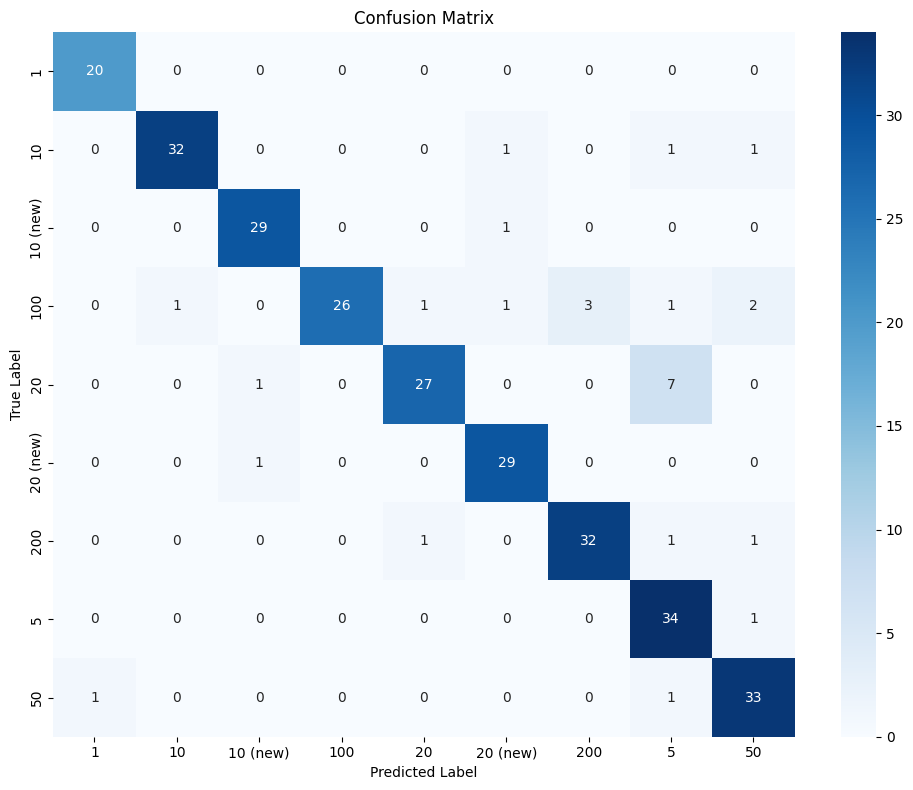


Classification Report:
              precision    recall  f1-score   support

           1     0.9524    1.0000    0.9756        20
          10     0.9697    0.9143    0.9412        35
    10 (new)     0.9355    0.9667    0.9508        30
         100     1.0000    0.7429    0.8525        35
          20     0.9310    0.7714    0.8438        35
    20 (new)     0.9062    0.9667    0.9355        30
         200     0.9143    0.9143    0.9143        35
           5     0.7556    0.9714    0.8500        35
          50     0.8684    0.9429    0.9041        35

    accuracy                         0.9034       290
   macro avg     0.9148    0.9101    0.9075       290
weighted avg     0.9126    0.9034    0.9028       290


Saved final model to c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\EfficientNetB0\effnet_b0_transfer_final.keras


In [10]:
print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)

model.load_weights(str(CHECKPOINT_PATH_FT))
print(f"Loaded best weights from {CHECKPOINT_PATH_FT}")

test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Save final model
model.save(str(FINAL_MODEL_PATH))
print(f"\nSaved final model to {FINAL_MODEL_PATH}")

In [11]:
def plot_training_curves(history, test_acc=None, test_loss=None):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs_range = range(1, len(acc) + 1)
    
    axes[0].plot(epochs_range, acc, 'b-', label='Train Acc', linewidth=2)
    axes[0].plot(epochs_range, val_acc, 'r-', label='Val Acc', linewidth=2)
    if test_acc is not None:
        axes[0].axhline(y=test_acc, linestyle='--', color='green', 
                       label=f'Test Acc: {test_acc:.4f}', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    axes[1].plot(epochs_range, loss, 'b-', label='Train Loss', linewidth=2)
    axes[1].plot(epochs_range, val_loss, 'r-', label='Val Loss', linewidth=2)
    if test_loss is not None:
        axes[1].axhline(y=test_loss, linestyle='--', color='green', 
                       label=f'Test Loss: {test_loss:.4f}', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

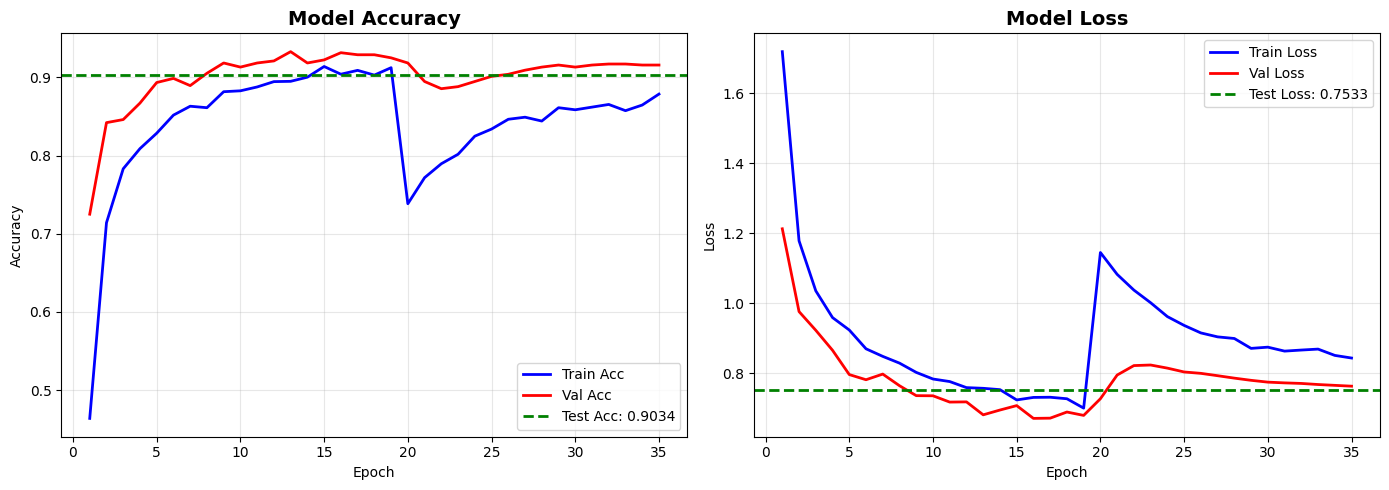

In [12]:
# Combine training histories for complete visualization
def combine_histories(hist1, hist2):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return type('History', (), {'history': combined})()

full_history = combine_histories(history_fe, history_ft)
plot_training_curves(full_history, test_acc=test_acc, test_loss=test_loss)